In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip data/
!wget http://images.cocodataset.org/zips/val2017.zip data/
!wget http://images.cocodataset.org/zips/test2017.zip data/

In [2]:
!unzip train2017.zip
!unzip val2017.zip
!unzip test2017.zip

In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

In [4]:
from pycocotools.coco import COCO

In [5]:
# annotations/instancesfree
# {dataset}2017.json
path = "annotations/instances_train2017.json"
data = COCO(path)

In [6]:
import numpy as np
import cv2
from os.path import join

In [7]:
i = 0
images, masks = [], []
for imgId in data.getImgIds():
    
    img = data.loadImgs(imgId)[0]
    
    valid = False
    anns = data.loadAnns(data.getAnnIds(imgId))

    mask = np.zeros((img["height"], img["width"]), dtype=np.byte)
    for ann in anns:
        
        # category id of person is 1
        if ann["category_id"] == 1:
            seg = data.annToMask(ann)
            mask += seg
            valid = True
    
    # if contains person
    if valid:
        
        file_name = img["file_name"]
        # {dataset}2017
        frame = cv2.imread(join("train2017", file_name))
        # frames/{dataset}
        cv2.imwrite(join("data/frames/train", file_name), frame)
        # masks/{dataset}
        cv2.imwrite(join("data/masks/train", file_name), mask)
        i += 1

In [8]:
# input image shape
img_shape = (256, 256)
batch_size = 16
n_train = 500 * batch_size
n_val = 100 * batch_size

In [9]:
import cv2
import glob
from os.path import join, expanduser
import numpy as np

In [10]:
# this handles all requests for data
class generator:
    
    def __init__(self, frames_dir, masks_dir, img_shape, n_data=None):
        
        frames_path = glob.glob(join(frames_dir, "*.jpg"))
        self.frames_path = sorted(frames_path, key=lambda path: int(path.split('/')[-1].split('.')[0]))
        
        masks_path = glob.glob(join(masks_dir, "*.jpg"))
        self.masks_path = sorted(masks_path, key=lambda path: int(path.split('/')[-1].split('.')[0]))
        
        # use all samples
        if n_data is None:
            n_data = len(frames_path)
        self.n_data = n_data
        
        self.img_shape = img_shape
        # used for shuffling
        self.order = np.arange(n_data)
        
    def __getitem__(self, key):
        
        if isinstance(key, slice):
            start, stop, step = key.indices(self.n_data)
            frames, masks = [], []
            
            for i in range(start, stop):
                frame, mask = self.get_data(
                    self.frames_path[self.order[i]], self.masks_path[self.order[i]]
                )
                frames.append(frame)
                masks.append(mask)
                
            return np.array(frames), np.array(masks)
        else:
            return self.get_data(
                self.frames_path[self.order[key]], self.masks_path[self.order[key]]
            )
    
    def __len__(self):
        return self.n_data
    
    def get_data(self, frame_path, mask_path):
        
        frame = cv2.imread(frame_path).astype(np.float32)
        mask = cv2.imread(mask_path).astype(np.float32)[:,:,:1]
        
        return frame, mask
    
    def iterator(self, batch_size=None, shuffle=False):
        
        if batch_size is None :
            batch_size = self.n_data
        
        base = 0
        while True:
            
            if shuffle and base == 0:
                np.random.shuffle(self.order)
            
            # yield makes function iterateble
            yield self[base:base + batch_size]

            base += batch_size
            # ensure the iterator runs forever
            if base + batch_size > self.n_data:
                base = 0

In [11]:
train_frames_dir = "data/frames/train"
train_masks_dir = "data/masks/train"
train_generator = generator(
    train_frames_dir, 
    train_masks_dir, 
    img_shape, 
    n_train
)

val_frames_dir = "data/frames/val"
val_masks_dir = "data/masks/val"
val_generator = generator(
    val_frames_dir, 
    val_masks_dir, 
    img_shape, 
    n_val
)

In [12]:
import matplotlib.pyplot as plt

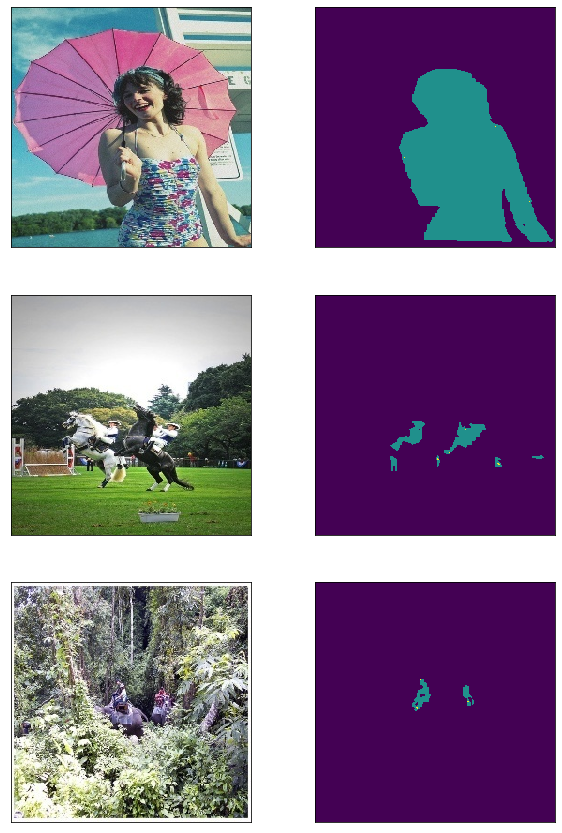

In [13]:
n_show = 3
plt.figure(figsize=(10, 5 * n_show))

for i in range(n_show):
    frame, mask = train_generator[i]
    frame = frame.astype(np.int32)
    mask = mask.astype(np.int32)

    plt.subplot(1 * n_show , 2, i * 2 + 1)
    # cv2 read image in BGR mode
    plt.imshow(frame[:,:,::-1])

    plt.xticks([])
    plt.yticks([])

    plt.subplot(n_show, 2, i * 2 + 2)
    plt.imshow(mask[:,:,0])

    plt.xticks([])
    plt.yticks([])

plt.show()

In [14]:
import segmentation_models as sm
import keras

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [15]:
model = sm.Unet("resnet34", input_shape=img_shape + (3, ))

optimizer = keras.optimizers.Adam(1e-4)
loss = sm.losses.bce_jaccard_loss
metrics = [sm.metrics.iou_score]

model.compile(optimizer, loss,  metrics)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint("./best-unet.h5", 
        save_weights_only=True, 
        save_best_only=True, 
        mode="min"
    ), 
    keras.callbacks.ReduceLROnPlateau()
]

train_iter = train_generator.iterator(batch_size, True)
val_iter = val_generator.iterator(batch_size, True)

In [17]:
history = model.fit_generator(
    train_iter, 
    steps_per_epoch=len(train_generator) / batch_size, 
    epochs=15, 
    callbacks=callbacks, 
    validation_data=val_iter, 
    validation_steps=len(val_generator) / batch_size
)

model.save_weights("./last-unet.h5")

Epoch 1/15
500/500 [==============================] - 437s 874ms/step - loss: 0.8917 - iou_score: 0.4048 - val_loss: 0.7412 - val_iou_score: 0.5466
Epoch 2/15
500/500 [==============================] - 410s 821ms/step - loss: 0.5389 - iou_score: 0.6208 - val_loss: 0.6543 - val_iou_score: 0.6321
Epoch 3/15
500/500 [==============================] - 410s 820ms/step - loss: 0.4219 - iou_score: 0.7079 - val_loss: 0.5404 - val_iou_score: 0.6829
Epoch 4/15
500/500 [==============================] - 410s 819ms/step - loss: 0.3619 - iou_score: 0.7521 - val_loss: 0.3905 - val_iou_score: 0.6793
Epoch 5/15
500/500 [==============================] - 410s 819ms/step - loss: 0.3240 - iou_score: 0.7799 - val_loss: 0.3069 - val_iou_score: 0.6950
Epoch 6/15
500/500 [==============================] - 410s 821ms/step - loss: 0.3004 - iou_score: 0.7960 - val_loss: 0.8698 - val_iou_score: 0.7091
Epoch 7/15
500/500 [==============================] - 409s 819ms/step - loss: 0.2794 - iou_score: 0.8104 - val_l

In [18]:
val_loss, val_iou_score = model.evaluate_generator(
    val_iter, 
    steps=n_val / batch_size
)
print(f"val_loss: {val_loss:1.4f} - val_iou_score: {val_iou_score:1.4f}")

val_loss: 0.4521 - val_iou_score: 0.7141


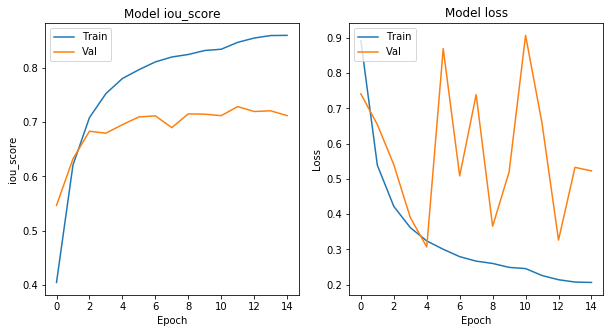

In [19]:
# our generator actually changes data every epoch, 
# this makes it longer to train, but can prevent model from over-fitting

# plot training and validation iou_score values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [20]:
model = sm.Unet("resnet34", input_shape=img_shape + (3, ))

optimizer = keras.optimizers.Adam(1e-4)
loss = sm.losses.bce_jaccard_loss
metrics = [sm.metrics.iou_score]

model.compile(optimizer, loss,  metrics)
model.load_weights("best-unet.h5")

In [21]:
results_source_dir = "data/results/source"
results_dir = "data/results"

results_source_path = glob.glob(join(results_source_dir, "*.jpg"))
n_test = len(results_source_path)

In [22]:
frames = []
for path in results_source_path:   
    
    frames.append(cv2.imread(path))

frames = np.array(frames)
predicts = model.predict(frames)

# write predictions into results
for i in range(n_test):
    
    name = results_source_path[i].split("/")[-1]
    
    mask = np.repeat(predicts[i], 3, axis=2)
    frames[i][mask < 0.5] = 0
    
    cv2.imwrite(
        join("data/results", name), 
        frames[i]
    )

In [23]:
results_path = glob.glob(join(results_dir, "*.jpg"))
order = np.arange(n_test)
np.random.shuffle(order)

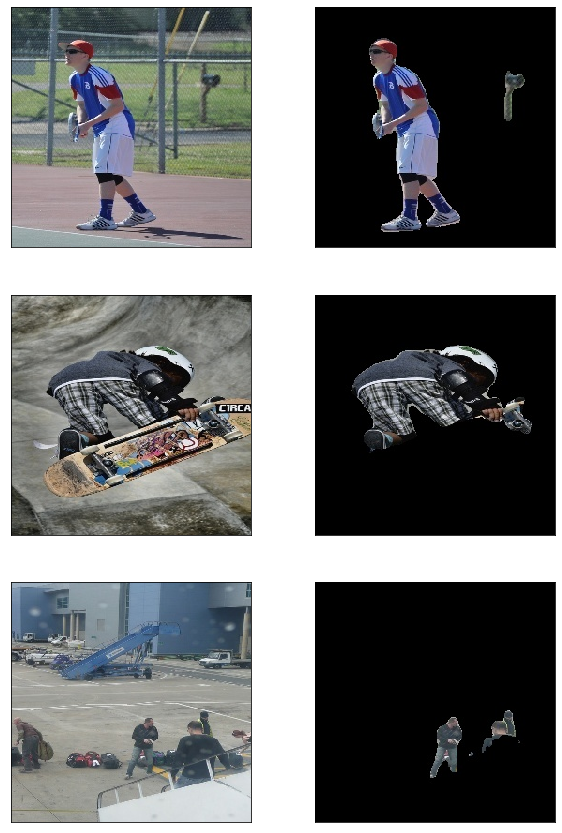

In [24]:
n_show = 3
plt.figure(figsize=(10, 5 * n_show))

for i in range(n_show):
    
    idx = order[i]

    source = cv2.imread(
        results_source_path[idx]
    )
    
    plt.subplot(n_show, 2, i * 2 + 1)
    plt.imshow(source[:,:,::-1])
    
    plt.xticks([])
    plt.yticks([])

    result = cv2.imread(
        results_path[idx]
    )

    plt.subplot(n_show, 2, i * 2 + 2)
    plt.imshow(result[:,:,::-1])
    
    plt.xticks([])
    plt.yticks([])
    
plt.show()